In [39]:
# Import Packages
import numpy as np
import pandas as pd
import pyodbc

# Get Current time
import datetime 

# For Graphics
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data into test and train subsets
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For saving the model
from sklearn.externals import joblib 

# For Confusion Matrix
from sklearn import metrics

# For ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

# For Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For Feature Selection
from sklearn.feature_selection import chi2, SelectKBest

# Settings to view all columns and rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

#to ignore the warning messages from being printed
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_orig = pd.read_csv('agent_churn.csv')
df_orig.head()

,Agent Number,Date_of_Appointment,Date_of_Termination,Commission Class,Pay Method,Pay Frequency,Agent Type,Agent Branch Code,Agent Reporting Level,Agent Date of Birth,Agent Gender,Number_of_Policies,Number_of_Claims,Total_Claim_Amount,Total_Payment_Amount,Total_Commission_Amount,Churn
0,50001187,20150526,NaN,3,DC,12,AM,10,1,19910507.0,M,5,0,0.0,0.0,0.0,0
1,50002503,20151214,NaN,3,CQ,12,AG,10,1,19830404.0,M,4,0,0.0,0.0,0.0,0
2,50004847,20200101,NaN,3,CQ,12,BR,10,1,19800101.0,M,0,0,0.0,0.0,0.0,0
3,50040992,20230104,NaN,3,CQ,12,AG,10,1,19750101.0,M,1,0,0.0,0.0,0.0,0
4,50041143,20230101,NaN,2,CQ,12,AM,10,1,19880101.0,M,0,0,0.0,0.0,0.0,0


# Data treatment

In [3]:
df_work = df_orig.copy()

In [4]:
# Separate features into categorical and numerical category
cat_vars = ['Commission Class','Pay Method','Pay Frequency','Agent Type','Agent Branch Code',
            'Agent Reporting Level','Agent Gender']

num_vars = ['Number_of_Policies', 'Number_of_Claims', 'Total_Claim_Amount','Total_Payment_Amount','Total_Commission_Amount']

date_vars = ['Date_of_Appointment', 'Date_of_Termination', 'Agent Date of Birth' ]

In [5]:
# Convert date columns

for var in date_vars:
    #df_work[var] = df_work[var].astype('category')
    #df_work[var] = datetime.datetime.strptime(var, '%Y-%m-%d')
    df_work[var]=pd.to_datetime(df_work[var].astype(str), format='%Y%m%d')

In [6]:
# Convert to 'category' object type
for var in cat_vars:
    df_work[var] = df_work[var].astype('category')

In [7]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_work[var], prefix=var)
    dummy_data = df_work.join(cat_list)
    df_work = dummy_data

In [8]:
df_work.shape

(3631, 42)

In [9]:
# Remove original columns for which dummy variables have been created
vars_remove = ['Commission Class','Pay Method','Pay Frequency','Agent Type','Agent Branch Code',
            'Agent Reporting Level','Agent Gender']

for var in vars_remove:
    df_work=df_work.drop(var, axis=1)

In [10]:
# Normalize numerical columns
scaler = MinMaxScaler()
df_work['Number_of_Policies'] = scaler.fit_transform(df_work['Number_of_Policies'].values.reshape(-1,1))
df_work['Number_of_Claims'] = scaler.fit_transform(df_work['Number_of_Claims'].values.reshape(-1,1))
df_work['Total_Claim_Amount'] = scaler.fit_transform(df_work['Total_Claim_Amount'].values.reshape(-1,1))
df_work['Total_Payment_Amount'] = scaler.fit_transform(df_work['Total_Payment_Amount'].values.reshape(-1,1))
df_work['Total_Commission_Amount'] = scaler.fit_transform(df_work['Total_Commission_Amount'].values.reshape(-1,1))

# Feature Engineering

In [10]:
# Get current date
current_time = datetime.datetime.now() 

In [11]:
# Create a new column 'Age' on the basis of date of birth of agent
df_work['age'] = current_time - df_work['Agent Date of Birth']

In [12]:
# Create a new column named 'service period' on the basis of difference between Agent Date of Registration and Termination.
# In case date of Termination is null we will replace it with current date and compute

service_period=[]

for Date_of_Termination,Date_of_Appointment in zip(df_work.iloc[:,2], df_work.iloc[:,1]):
    if Date_of_Termination is pd.NaT:
        service_period.append(abs(current_time-Date_of_Appointment))
    else:
        service_period.append(abs(Date_of_Termination-Date_of_Appointment))
    #print(Date_of_Termination)
    #print(Date_of_Appointment)


In [14]:
# Append the new column to dataframe
df_work['Service_Period']=service_period

# Remove the orginal columns
df_work=df_work.drop('Date_of_Appointment', axis=1)
df_work=df_work.drop('Date_of_Termination', axis=1)
df_work=df_work.drop('Agent Date of Birth', axis=1)

# Remove Agent Number since it is not critical for prediction
df_work=df_work.drop('Agent Number', axis=1)

KeyError: "['Date_of_Appointment'] not found in axis"

In [15]:
# Check contents once
df_work.head()

,Number_of_Policies,Number_of_Claims,Total_Claim_Amount,Total_Payment_Amount,Total_Commission_Amount,Churn,Commission Class_1,Commission Class_2,Commission Class_3,Pay Method_CQ,Pay Method_DC,Pay Frequency_12,Agent Type_0,Agent Type_7,Agent Type_AG,Agent Type_AM,Agent Type_AR,Agent Type_BA,Agent Type_BM,Agent Type_BR,Agent Type_CR,Agent Type_DM,Agent Type_GM,Agent Type_SM,Agent Type_UM,Agent Branch Code_10,Agent Reporting Level_1,Agent Reporting Level_2,Agent Gender_,Agent Gender_F,Agent Gender_M,age,Service_Period
0,5,0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,10572 days 16:22:20.475588,1787 days 16:22:20.475588
1,4,0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,13527 days 16:22:20.475588,1585 days 16:22:20.475588
2,0,0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,14716 days 16:22:20.475588,106 days 16:22:20.475588
3,1,0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,16542 days 16:22:20.475588,992 days 07:37:39.524412
4,0,0,0.0,0.0,0.0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,11794 days 16:22:20.475588,989 days 07:37:39.524412


In [16]:
# Normalize the new columns 
scaler = MinMaxScaler()
df_work['age'] = scaler.fit_transform(df_work['age'].values.reshape(-1,1))
df_work['Service_Period'] = scaler.fit_transform(df_work['Service_Period'].values.reshape(-1,1))

In [18]:
# Create separate dataset for feature and target columns
x01 = df_work.drop('Churn', axis=1)
y01 = df_work['Churn']

# Feature Selection

In [18]:
#NOT executing this part of feature selection and using TPOT to perform auto feature selection.
bestfeatures=SelectKBest(score_func=chi2, k=10)
fit=bestfeatures.fit(x,y)
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(x.columns)
#concatenate two dataframes
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Specs','Score'] #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) #print 10 best features

                      Specs       Score
4   Total_Commission_Amount  179.461095
0        Number_of_Policies   79.038735
1          Number_of_Claims   51.598942
17            Agent Type_BM   35.968226
13            Agent Type_AG   16.425783
2        Total_Claim_Amount   11.655611
31           Service_Period    3.602116
14            Agent Type_AM    1.430251
6        Commission Class_2    1.252122
27           Agent Gender_     0.666482


In [19]:
#NOT executing this part of feature selection and using TPOT to perform auto feature selection.
# Get top features
top_features = ['Total_Commission_Amount', 'Number_of_Policies', 'Number_of_Claims','Agent Type_BM',
               'Agent Type_AG', 'Total_Claim_Amount', 'Service_Period', 'Agent Type_AM', 'Commission Class_2', 
               'Agent Gender_ ',]

In [20]:
#NOT executing this part of feature selection and using TPOT to perform auto feature selection.
# Create new dataset with only top features
x01=x[top_features]
y01=y

# To handle class imbalance performing SMOTE

In [19]:
# To handle class imbalance performing SMOTE

from imblearn.over_sampling import SMOTE
SMO = SMOTE(random_state=11)

#X4_train, X4_test, Y4_train, Y4_test = train_test_split(X_train,Y_train, test_size=0.20)
x01_smo,y01_smo = SMO.fit_sample(x01, y01)
columns = x01.columns

x01_smo = pd.DataFrame(data = x01_smo, columns = columns )
y01_smo = pd.DataFrame(data = y01_smo, columns = ['Churn'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(x01_smo))
print("Number of Churned agents in oversampled data",len(y01_smo[y01_smo['Churn']== 0 ]))
print("Number of Non Churned agents in oversampled data",len(y01_smo[y01_smo['Churn']== 1 ]))
print("Proportion of Non Churned agents in oversampled data is ",len(y01_smo[y01_smo['Churn']== 0])/len(x01_smo))
print("Proportion of Churned Agents in oversampled data is ",len(y01_smo[y01_smo['Churn']== 1 ])/len(x01_smo))

length of oversampled data is  7238
Number of Churned agents in oversampled data 3619
Number of Non Churned agents in oversampled data 3619
Proportion of Non Churned agents in oversampled data is  0.5
Proportion of Churned Agents in oversampled data is  0.5


In [20]:
# Perform Test/Train Split
x01_train_smo, x01_test_smo, y01_train_smo, y01_test_smo = train_test_split(x01_smo, y01_smo, test_size=0.3,random_state=11)


In [21]:
x01_train_smo.shape, x01_test_smo.shape, y01_train_smo.shape, y01_test_smo.shape

((5066, 32), (2172, 32), (5066, 1), (2172, 1))

# Model Application

# 1. Logistic Regression

In [23]:
# Define grid
C = np.logspace(0,5,10)
param_grid = dict( C=C)

# Model
logreg=LogisticRegression(solver='lbfgs',max_iter=1000)

# Define Evaluation Procedure
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=11)

# Define Grid Search
grid=GridSearchCV(estimator=logreg, param_grid=param_grid, n_jobs=1, cv=cv, scoring='roc_auc')

# Execute Grid Search
grid_result=grid.fit(x01_train_smo, (y01_train_smo.values.ravel()))

In [24]:
# Print best model parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.964528 using {'C': 46.4158883361278}


In [25]:
grid_result.best_estimator_

LogisticRegression(C=46.4158883361278, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
# Saving the best model
bestlogreg= LogisticRegression(C=46.4158883361278, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# Fit the model on train data
bestlogreg.fit(x01_train_smo, y01_train_smo)

LogisticRegression(C=46.4158883361278, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
# Make Predictions
y01_pred=bestlogreg.predict(x01_test_smo)

In [44]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y01_test_smo , y01_pred)
cnf_matrix  

array([[1007,   85],
       [ 184,  896]], dtype=int64)

In [45]:
# Get Accuracy Scores - y01_smo
#print("Accuracy:",metrics.accuracy_score(y01_smo, y01_pred))
#print("Precision:",metrics.precision_score(y01_smo, y01_pred))
#print("Recall:",metrics.recall_score(y01_smo, y01_pred))
#print("f1 score: ", f1_score(y01_smo, y01_pred))

# # Get Accuracy Scores - y01_test_smo
print("Accuracy:",metrics.accuracy_score(y01_test_smo, y01_pred))
print("Precision:",metrics.precision_score(y01_test_smo, y01_pred))
print("Recall:",metrics.recall_score(y01_test_smo, y01_pred))
print("f1 score: ", f1_score(y01_test_smo, y01_pred))


Accuracy: 0.8761510128913443
Precision: 0.9133537206931702
Recall: 0.8296296296296296
f1 score:  0.8694808345463367


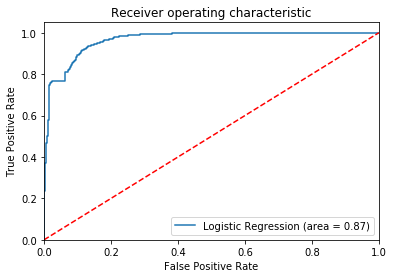

In [37]:
# Print ROC AUC Curve y01_smo x01_smo smote set without t/t split
 
logit_roc_auc = roc_auc_score(y01_smo, bestlogreg.predict(x01_smo))
fpr, tpr, thresholds = roc_curve(y01_smo, bestlogreg.predict_proba(x01_smo)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

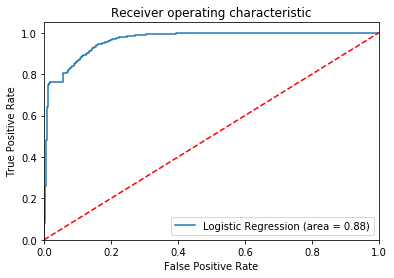

In [46]:
# Print ROC AUC Curve 
 
logit_roc_auc = roc_auc_score(y01_test_smo, bestlogreg.predict(x01_test_smo))
fpr, tpr, thresholds = roc_curve(y01_test_smo, bestlogreg.predict_proba(x01_test_smo)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# 2. Using TPOT

In [22]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, verbosity=2, max_time_mins=60, n_jobs = -1)
tpot.fit(x01_train_smo, y01_train_smo)
print(tpot.score(x01_test_smo, y01_test_smo))

Generation 1 - Current best internal CV score: 0.9986179664363277
Generation 2 - Current best internal CV score: 0.9986179664363277
Generation 3 - Current best internal CV score: 0.9986179664363277
Generation 4 - Current best internal CV score: 0.9990128331688055
Generation 5 - Current best internal CV score: 0.9990128331688055

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=8, max_features=0.3, min_samples_leaf=7, min_samples_split=10, n_estimators=100, subsample=0.8)
0.998158379373849


In [32]:
Fit_pipeline=tpot.fitted_pipeline_
Fit_pipeline

Pipeline(memory=None,
         steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.5, loss='deviance',
                                            max_depth=8, max_features=0.3,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=7,
                                            min_samples_split=10,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            presort='deprecated',
                                

In [24]:
print(tpot.score(x01_test_smo, y01_test_smo))

0.998158379373849


In [33]:
# Saving the best model
from sklearn.ensemble import RandomForestClassifier
bestTPOT= Fit_pipeline

In [34]:
bestTPOT.fit(x01_train_smo, y01_train_smo)

Pipeline(memory=None,
         steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.5, loss='deviance',
                                            max_depth=8, max_features=0.3,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=7,
                                            min_samples_split=10,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            presort='deprecated',
                                

In [35]:
# Make Predictions
y01_pred_TPOT=bestTPOT.predict(x01_test_smo)

In [36]:
cnf_matrix = metrics.confusion_matrix(y01_test_smo , y01_pred_TPOT)
cnf_matrix  

array([[1091,    1],
       [   0, 1080]], dtype=int64)

In [37]:
# # Get Accuracy Scores - y01_test_smo
print("Accuracy:",metrics.accuracy_score(y01_test_smo, y01_pred_TPOT))
print("Precision:",metrics.precision_score(y01_test_smo, y01_pred_TPOT))
print("Recall:",metrics.recall_score(y01_test_smo, y01_pred_TPOT))
print("f1 score: ", f1_score(y01_test_smo, y01_pred_TPOT))

Accuracy: 0.9995395948434622
Precision: 0.9990749306197965
Recall: 1.0
f1 score:  0.9995372512725589


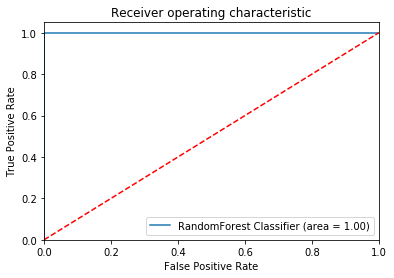

In [38]:
# Print ROC AUC Curve 
 
TPOT_roc_auc = roc_auc_score(y01_test_smo, bestTPOT.predict(x01_test_smo))
fpr, tpr, thresholds = roc_curve(y01_test_smo, bestTPOT.predict_proba(x01_test_smo)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest Classifier (area = %0.2f)' % TPOT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<img src="https://github.com/aniacharya/MachineLearning/blob/master/images/DXC.png?raw=true" width="240" height="360" />



In [ ]:
print('Proportion of the classes in the data:')
print(data['Class'].value_counts() / len(data))